In [1]:
import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras
from sklearn.model_selection import train_test_split

from graphing import *
from file_related import *

SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:

def split_dataframe(df, for_user = None, val_size = 0.25, test_size =  0.01, seed = None):
    """
    split the dataframe into train, validation and test splits based on the same seed
    Empty dataframes if no data present
    """
    # split into train, validation and test data using sklearn and return dfs for each
    if for_user!=None:
        df = df[df["User"] == for_user]
    if df.shape[0] == 0:
        # if no data for the user, then return 9 empty dfs as per the api
        # print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return (df for _ in range(9))
    df_train, df_test = train_test_split(df,
                                         test_size = test_size,
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train,
                                         test_size = val_size,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)

    return df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user, \
        df_train, df_train_class, df_train_user

In [3]:
def init_model(init_seed=None):
    """
    initialise and return a model 
    """
    model = keras.Sequential([
        keras.layers.Flatten(),
#         keras.layers.Dense(4096, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
#         keras.layers.Dense(1024, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
#         keras.layers.Dense(128, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed))
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model


def init_users(df, averaging_methods, averaging_metric = "accuracy", seed = None):
    """
    Requires the DF to contain a "User" column giving numeric identity to a user
    0 to unique_user_count-1
    
    Averaging method is a list of methods out of which a random one is selected
    
    initialise users based on dataframe given and assign random averaging method
    to them based on the list passed in.
    returns a dictionary of users(key: user object) and a global user object
    """    
    print("Initialising User instances...")
    users = dict()
    num_users = df["User"].nunique()

    for user_id in range(-1,num_users):

        i = user_id # for global user to get all the data

        if user_id < 0: # for global user with id -1
            user_id = None

        df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user,\
        df_train, df_train_class, df_train_user = split_dataframe(df = df, 
                                                                  for_user=user_id, 
                                                                  seed = seed)
        user_id = i
        if df_train.shape[0]==0:
            print(f"User {user_id} has no data, no instance created...")
            continue

        model = init_model(init_seed = seed)
        
        option = np.random.RandomState(seed).randint(0,len(averaging_methods))

        users[user_id] = User(user_id=user_id,
                          model = model,
                          averaging_method = averaging_methods[option],
                          averaging_metric = averaging_metric,
                          train_class = df_train_class,
                          train_data = df_train,
                          val_class = df_val_class,
                          val_data = df_val,
                          test_class = df_test_class,
                          test_data = df_test)

    global_user = users.pop(-1)
    global_user.set_averaging_method(averaging_methods[0])
    print(f"{len(users.keys())} User instances and a global user created!")
    return users, global_user

In [4]:
def train_users(users, epochs,
                new_weights = None,
                train_user_verbose_evaluate = 0,
                train_user_verbose_fit = False,
                verbose = True):
    """
    this method is used to train all users on the passed in epochs value
    """
    
    for user in users.values():
        # if user.get_id() < 0:
        #     continue

        if verbose:
            message = f"User {user.get_id()} being trained on the model..."
            print(message)

        user.train(
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            verbose_fit = train_user_verbose_fit,
            verbose_evaluate = train_user_verbose_evaluate
        )

        if verbose:
            message = f"User {user.get_id()} done!"
            print(message)

    return



def train_fed(epochs, rounds, users,
              verbose = True,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_pre = False,
             averaging_post = False,
             averaging_metric = "accuracy"):
    """
    this function trains a federation of users using 'strat' stratergy
    central or personalised
    
    central is where all the users send data to a server and the server
    sends back new weights
    
    personalised is where all the users are sent each others data
    and the user tests how their own test data performs on everyone 
    elses models. Based on their policy, they then decide what way
    to average the data.
    """

    for i in range(rounds):
        new_weights = None
    
        # users' weights will not be updated till round i+1
        
        if verbose:
            message = f"{'*'*32} {i:^4} {'*'*32}"
            print(message)

        train_users(users = users, epochs = EPOCHS,
                   new_weights = new_weights,
                   verbose = train_user_verbose,
                   train_user_verbose_evaluate = train_user_verbose_evaluate,
                   train_user_verbose_fit = train_user_verbose_fit)
        if strat == "central":
            # calc new weight and pass it to train users 
            # in next round for the users to update their
            # model and retrain on their local train data
            new_weights = averaging_method(users = users, 
                                  pre = averaging_pre,
                                  post = averaging_post, 
                                  metric = averaging_metric)
    
        elif strat == "personalised":
            new_weights = dict()
            for user in users.values():
                # gather everyones models/weights in a dict
                # and pass it to train users in next round
                new_weights[user.get_id()] = user.get_weights()
            
        if verbose:
            message = f"{'*'*32} {'DONE':^4} {'*'*32}"
            print(message)
    return


In [8]:
# SEED = 0
df = read_file("../dataset/allUsers.lcl.csv")
df = shuffle_df(df, SEED)
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
# df.head()

In [9]:
DEVICE = '/cpu:0'
ROUNDS = 2
EPOCHS = 16 # 16 is good

In [24]:
# forces tensorfor to the a particular device to run things
with tf.device(DEVICE):
#     averaging_methods = [Average.all]
#      # return a dictionary of users with data
    users_all, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
#     train_fed(users = users_all, rounds = ROUNDS,
#               epochs = EPOCHS,
#               strat = "central",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_method = Average.all,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
#     # return a dictionary of users with data
#     users_all_2, global_user = init_users(df = df, 
#                                         averaging_methods = averaging_methods, 
#                                         seed = SEED)
#     train_fed(users = users_all_2, rounds = ROUNDS,
#               epochs = EPOCHS,
              
#               strat = "personalised",
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_post = True,
#               averaging_metric = "accuracy")
    
    
# #     users, global_user = init_users(df) # return a dictionary of users with data
    
    print("Global user training and validation")
    global_user.train(epochs = EPOCHS*ROUNDS,
       verbose_fit = False,
       verbose_evaluate = False,
    )

Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
Global user training and validation


{'loss': [6.6801447277958745, 1.6336645512097945, 1.0038267144624111, 0.7695819447049187, 0.6468421424386899, 0.5739121594520521, 0.5302286964170123, 0.5006202844365946, 0.4765285373483046, 0.45440073781575874, 0.4367774348030046, 0.4199040474514244, 0.40505669008779416, 0.39292751976695206, 0.3809413435085789, 0.3693939143538532, 0.356433696481591, 0.3444556977826536, 0.33554819673004677, 0.3274309438149118, 0.3194900393274356, 0.3123049037521478, 0.30587003126924645, 0.30084893248864863, 0.2932372510551242, 0.2878858940422083, 0.2819722255913602, 0.27675293790694105, 0.27210909563124297, 0.2677238165115159, 0.2647748038825023, 0.259171626782642], 'sparse_categorical_accuracy': [0.59516495, 0.71419793, 0.75305605, 0.7725193, 0.79157275, 0.805436, 0.8169774, 0.82530904, 0.8322065, 0.840265, 0.8477088, 0.8546746, 0.86177695, 0.8647135, 0.868333, 0.874411, 0.87987435, 0.88397187, 0.88902545, 0.89025474, 0.89360106, 0.89797175, 0.89961076, 0.90118146, 0.90391314, 0.9058936, 0.9067814, 0.9

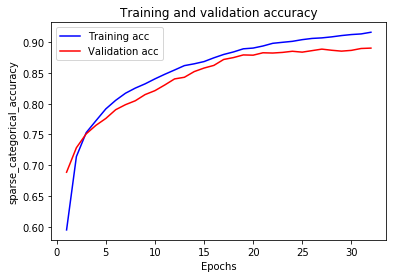

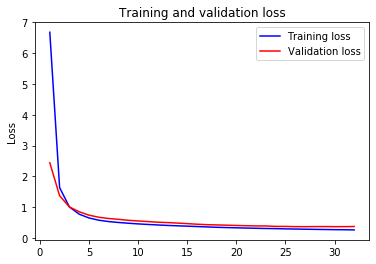

<Figure size 432x288 with 0 Axes>

In [25]:
    print(global_user.get_history()[-1].history)
    draw_graphs(global_user)
    

In [35]:
with tf.device(DEVICE):
    averaging_methods = [Average.std_dev]
    # return a dictionary of users with data
    users_std_dev, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_std_dev, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method =  Average.std_dev,
             averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
    users_std_dev_2, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_std_dev_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "personalised",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    

Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
User 7: 0.6000000238418579 < 0.8507546038657583
******************************** DONE ********************************
********************************  1   ********************************
User 7: 0.6000000238418579 < 0.8537296804784296
******************************** DONE ********************************
Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
******************************** DONE ********************************
********************************  1   ********************************
******************************** DONE ********************************


In [ ]:
with tf.device(DEVICE):
    averaging_methods = [Average.weighted_avg]
    
    # return a dictionary of users with data
    users_weighted_avg, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_weighted_avg, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.weighted_avg,
              averaging_post = True,
              averaging_metric = "accuracy")
    
    # return a dictionary of users with data
    users_weighted_avg_2, global_user = init_users(df = df, 
                                        averaging_methods = averaging_methods, 
                                        seed = SEED)
    train_fed(users = users_weighted_avg_2, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "personalised",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_post = True,
              averaging_metric = "accuracy")
    

In [36]:
ignore_first_n = 0
final_values = True



print("All")

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_all_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)

All
For p2p


NameError: name 'users_all_2' is not defined

Std deviation
For p2p
Final values for Pre-fit accuracy
Position                   Pre
Round                        1
Average               0.954848
Standard Deviation    0.104094
Minimum                    0.6
Maximum                      1
Name: 2, dtype: object
Final values for Post-fit accuracy
Position                 Post
Round                       1
Average               0.95882
Standard Deviation    0.10509
Minimum                   0.6
Maximum                     1
Name: 3, dtype: object



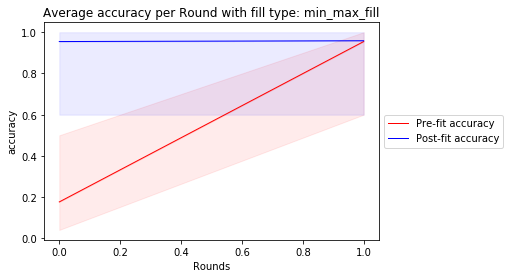

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.956044
3     1     0.979167
5     2     0.956522
7     4     1.000000
9     5     1.000000
11    6     1.000000
13    7     0.600000
15    8     1.000000
17    9     1.000000
19   10     0.958333
21   11     0.962963
23   12     1.000000
25   13     1.000000
Averaged: 0.9548483628493089

Final accuracy for Post-fit data
   User  Final Value
0     0     0.934066
2     1     1.000000
4     2     0.978261
6     4     1.000000
8     5     1.000000
10    6     1.000000
12    7     0.600000
14    8     0.985507
16    9     1.000000
18   10     0.979167
20   11     0.987654
22   12     1.000000
24   13     1.000000
Averaged: 0.9588196231768682



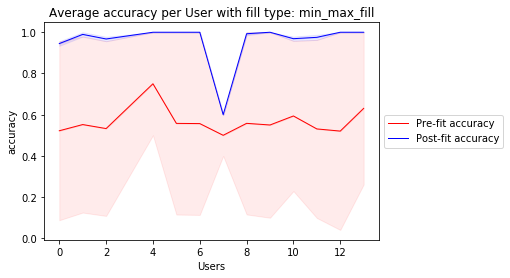

For central
Final values for Pre-fit accuracy
Position                   Pre
Round                        1
Average               0.954848
Standard Deviation    0.104094
Minimum                    0.6
Maximum                      1
Name: 2, dtype: object
Final values for Post-fit accuracy
Position                 Post
Round                       1
Average               0.95882
Standard Deviation    0.10509
Minimum                   0.6
Maximum                     1
Name: 3, dtype: object



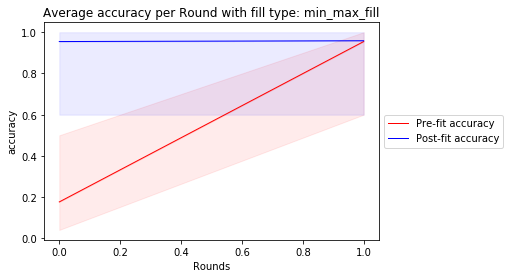

Final accuracy for Pre-fit data
   User  Final Value
1     0     0.956044
3     1     0.979167
5     2     0.956522
7     4     1.000000
9     5     1.000000
11    6     1.000000
13    7     0.600000
15    8     1.000000
17    9     1.000000
19   10     0.958333
21   11     0.962963
23   12     1.000000
25   13     1.000000
Averaged: 0.9548483628493089

Final accuracy for Post-fit data
   User  Final Value
0     0     0.934066
2     1     1.000000
4     2     0.978261
6     4     1.000000
8     5     1.000000
10    6     1.000000
12    7     0.600000
14    8     0.985507
16    9     1.000000
18   10     0.979167
20   11     0.987654
22   12     1.000000
24   13     1.000000
Averaged: 0.9588196231768682



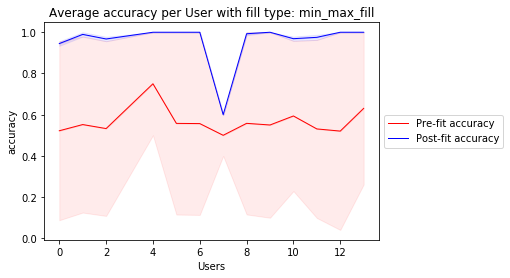

<Figure size 432x288 with 0 Axes>

In [37]:
ignore_first_n = 0
final_values = True

print("Std deviation")

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_std_dev_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)

In [30]:
ignore_first_n = 0
final_values = True

print("Weighted average")

print("For p2p")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg_2, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg_2, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)
print("For central")


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)
df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       metric = "accuracy",
                                       final_values = final_values)

Weighted average
For p2p


NameError: name 'users_weighted_avg_2' is not defined